<a href="https://colab.research.google.com/github/ThePyProgrammer/GaitMonitoringForParkinsonsDiseasePatients/blob/main/SMP%20(v1.1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Parkinsons

##Data Description

Parkinson's disease (PD) is one of the most common movement disorders, affecting approximately 1 million Americans (estimates range between 4 and 6.5 million people worldwide) and about 1% of older adults. In the US alone, 60,000 new cases are diagnosed each year. PD is a chronic and progressive neurological disorder that results in tremor, rigidity, slowness, and postural instability. A disturbed gait is a common, debilitating symptom; patients with severe gait disturbances are prone to falls and may lose their functional independence.

This database contains measures of gait from 93 patients with idiopathic PD (mean age: 66.3 years; 63% men), and 73 healthy controls (mean age: 66.3 years; 55% men). The database includes the vertical ground reaction force records of subjects as they walked at their usual, self-selected pace for approximately 2 minutes on level ground. Underneath each foot were 8 sensors ([Ultraflex Computer Dyno Graphy, Infotronic Inc.](http://www.infotronic.nl/#CDG)) that measure force (in Newtons) as a function of time. The output of each of these 16 sensors has been digitized and recorded at 100 samples per second, and the records also include two signals that reflect the sum of the 8 sensor outputs for each foot. For details about the format of the data, please see [this note](https://physionet.org/content/gaitpdb/1.0.0/format.txt).

With this information, one can investigate the force record as a function of time and location, derive measures that reflect the center-of-pressure as a function of time, and determine timing measures (e.g., stride time, swing time) for each foot as functions of time. Thus, one can study the stride-to-stride dynamics and the variability of these time series.

This database also includes demographic information, measures of disease severity (i.e., using the Hoehn & Yahr staging and/or the Unified Parkinson's Disease Rating Scale) and other related measures (available in HTML or xls spreadsheet format).

A subset of the database includes measures recorded as subjects performed a second task (serial 7 subtractions) while walking, as in the figure above, which shows excerpts of swing time series from a patient with PD (lower panels) and a control subject (upper panels), under usual walking conditions (at left) and when performing serial 7 subtractions (at right). Under usual walking conditions, variability is larger in the patient with PD (Coefficient of Variation = 2.7%), compared to the control subject (CV = 1.3%). Variability increases during dual tasking in the subject with PD (CV = 6.5%), but not in the control subject (CV = 1.2%). From Yogev et al. (reference [4] below).

Data format:
------------

Each line contains 19 columns:

| Column | Description |
|--------|-------------|
| 1 | Time (in seconds)|
| 2-9 | **Vertical ground reaction force** (VGRF, in Newton) on each of 8 sensors located under the left foot |
| 10-17 |VGRF on each of the 8 sensors located under the right foot |
| 18 | Total force under the left foot |
| 19 | Total force under the right foot |


When a person is comfortably standing with both legs parallel to each
other, sensor locations inside the insole can be described (according
to the [Infotronic website](http://www.infotronic.nl/)) as lying
approximately at the following (X,Y) coordinates, assuming that the
origin (0,0) is just between the legs and the person is facing towards
the positive side of the Y axis:

| Sensor | X    | Y    |
|--------|------|------|
| L1     | -500 | -800 |
| L2     | -700 | -400 |
| L3     | -300 | -400 |
| L4     | -700 | 0    |
| L5     | -300 | 0    |
| L6     | -700 | 400  |
| L7     | -300 | 400  |
| L8     | -500 | 800  |
| R1     | 500  | -800 |
| R2     | 700  | -400 |
| R3     | 300  | -400 |
| R4     | 700  | 0    |
| R5     | 300  | 0    |
| R6     | 700  | 400  |
| R7     | 300  | 400  |
| R8     | 500  | 800  |

The X and Y numbers are in an arbitrary coordinate system reflecting
the relative (arbitrarily scaled) positions of the sensors within each
insole. During walking, the sensors inside each insole remain at the
same relative position, but the two feet are no longer parallel to
each other. Thus, this coordinate system enables a calculation of a
proxy for the location of the center of pressure (COP) under each
foot.


Data file names:
----------------
These follow a common convention, e.g., ```GaCo01_02.txt```  or  ```JuPt03_06.txt```, where

- Ga, Ju or Si – indicate the study from which the data originated:
 - Ga - Galit Yogev et al ([dual tasking in PD; Eur J Neuro, 2005](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1460-9568.2005.04298.x))
 - Ju – Hausdorff et al ([RAS in PD; Eur J Neuro, 2007](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1460-9568.2007.05810.x))
 - Si - Silvi Frenkel-Toledo et al ([Treadmill walking in PD; Mov Disorders, 2005](https://onlinelibrary.wiley.com/doi/abs/10.1002/mds.20507))

- Co or Pt: Control subject or a PD Patient respectively

- 01: Subject number in the group

- A walk number of 10  (for the "Ga" study) indicates a dual-task walking,
where the subject was engaged in serial-7 subtraction while walking.

- A walk number of 01 refers to a usual, normal walk. 

The sampling rate was 100 Hz.

In [7]:
import numpy as np # main library for numeric calculations
import pandas as pd # main library for data analysis
import matplotlib.pyplot as plt # main library for data plotting
import seaborn as sns
sns.set() # mainly to set style of the plot

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error #technically not used

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from glob import glob
import re

from tqdm import tqdm_notebook

from itertools import product
from datetime import datetime, date, timedelta
from fbprophet import Prophet

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

import warnings
warnings.filterwarnings('ignore') # literally to ignore all the warnings that don't matter

%matplotlib inline
# to place plotting inside the diagram

uci = pd.read_csv("parkinsons.data")
demographics = pd.read_excel("demographics.xls", "Sheet1")
demographics

,ID,Study,Group,Subjnum,Gender,Age,Height (meters),Weight (kg),HoehnYahr,UPDRS,UPDRSM,TUAG,Speed_01 (m/sec),Speed_10
0,GaPt03,Ga,PD,3,female,82,1.45,50.0,3.0,20.0,10.0,36.34,NaN,0.778
1,GaPt04,Ga,PD,4,male,68,1.71,NaN,2.5,25.0,8.0,11.00,0.642,0.818
2,GaPt05,Ga,PD,5,female,82,1.53,51.0,2.5,24.0,5.0,14.50,0.908,0.614
3,GaPt06,Ga,PD,6,male,72,1.70,82.0,2.0,16.0,13.0,10.47,0.848,0.937
4,GaPt07,Ga,PD,7,female,53,1.67,54.0,3.0,44.0,22.0,18.34,0.677,0.579
5,GaPt08,Ga,PD,8,female,68,1.63,57.0,2.0,15.0,8.0,10.11,1.046,0.228
6,GaPt09,Ga,PD,9,male,69,1.60,68.0,3.0,34.0,17.0,12.70,0.894,1.253
7,GaPt12,Ga,PD,12,female,59,1.63,67.0,2.0,25.0,7.0,8.37,1.261,1.133
8,GaPt13,Ga,PD,13,male,70,1.68,53.0,2.0,38.0,21.0,15.51,0.726,0.798
9,GaPt14,Ga,PD,14,male,56,1.95,105.0,2.0,29.0,19.0,NaN,1.369,0.973


In [9]:
pd.set_option('display.max_rows', 20)

data = []
names = []
for i in sorted(glob("*.txt")):
  names.append(i)
  data.append(pd.read_table(i, names=["time"]+["VGRF_left_"+str(i) for i in range(1, 9)]+["VGRF_right_"+str(i) for i in range(1, 9)]+["VGRF_left", "VGRF_right"]).set_index("time"))

data[0]

,VGRF_left_1,VGRF_left_2,VGRF_left_3,VGRF_left_4,VGRF_left_5,VGRF_left_6,VGRF_left_7,VGRF_left_8,VGRF_right_1,VGRF_right_2,VGRF_right_3,VGRF_right_4,VGRF_right_5,VGRF_right_6,VGRF_right_7,VGRF_right_8,VGRF_left,VGRF_right
time,,,,,,,,,,,,,,,,,,
0.0000,199.10,87.34,91.08,24.09,21.12,87.67,87.23,64.57,163.90,79.86,112.42,50.82,13.75,102.74,144.98,79.53,662.20,748.00
0.0100,199.10,87.34,91.08,24.09,21.12,87.67,87.23,64.57,163.90,79.86,112.42,50.82,13.75,102.74,144.98,79.53,662.20,748.00
0.0200,199.10,87.34,91.08,24.09,21.12,87.67,87.23,62.59,163.90,79.86,112.42,50.82,13.75,102.74,144.98,79.53,660.22,748.00
0.0300,199.10,87.34,91.08,24.09,21.12,87.67,89.10,64.57,163.90,77.55,112.42,48.07,13.75,105.49,144.98,79.53,664.07,745.69
0.0400,199.10,87.34,91.08,24.09,21.12,87.67,87.23,62.59,163.90,77.55,112.42,50.82,13.75,105.49,144.98,79.53,660.22,748.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121.1315,305.91,85.14,58.08,0.00,0.00,0.00,0.00,0.00,15.73,11.66,4.73,33.88,33.00,255.42,432.19,147.29,449.13,933.90
121.1415,331.54,134.75,79.31,11.99,0.00,3.85,0.00,0.00,15.73,9.35,4.73,11.22,24.75,230.34,420.42,151.80,561.44,868.34
121.1515,352.44,181.94,102.96,39.60,0.00,17.49,2.97,0.00,13.97,9.35,4.73,5.61,19.25,192.39,402.82,154.00,697.40,802.12


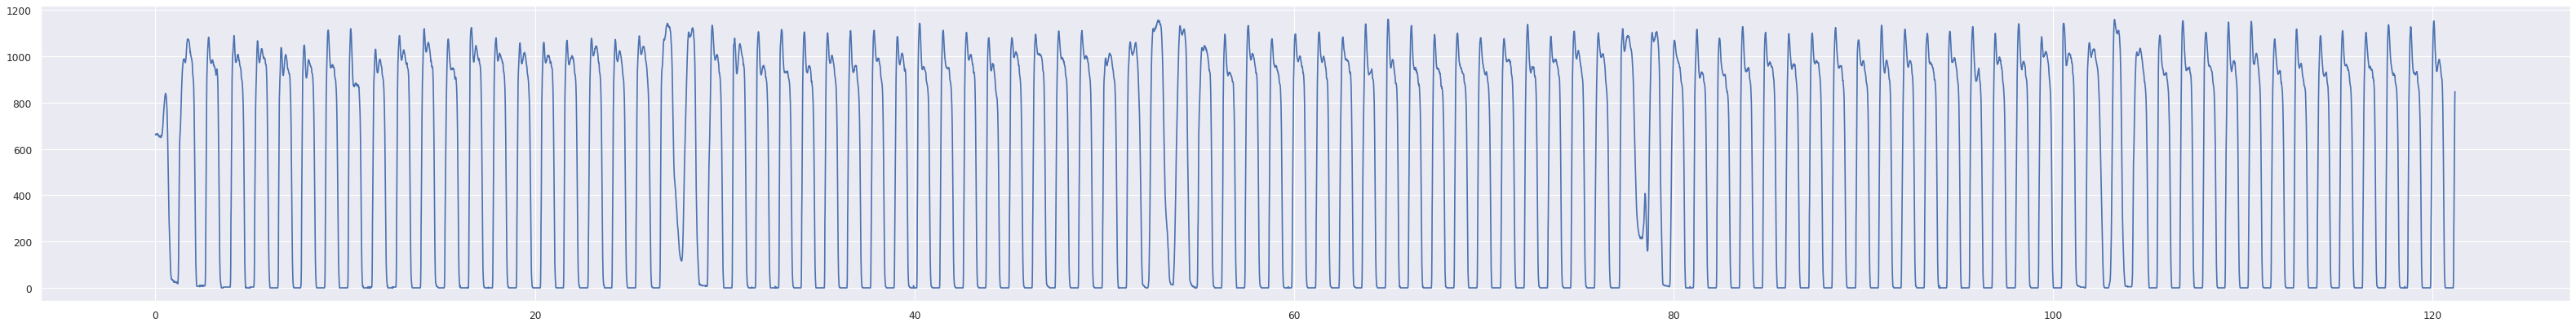

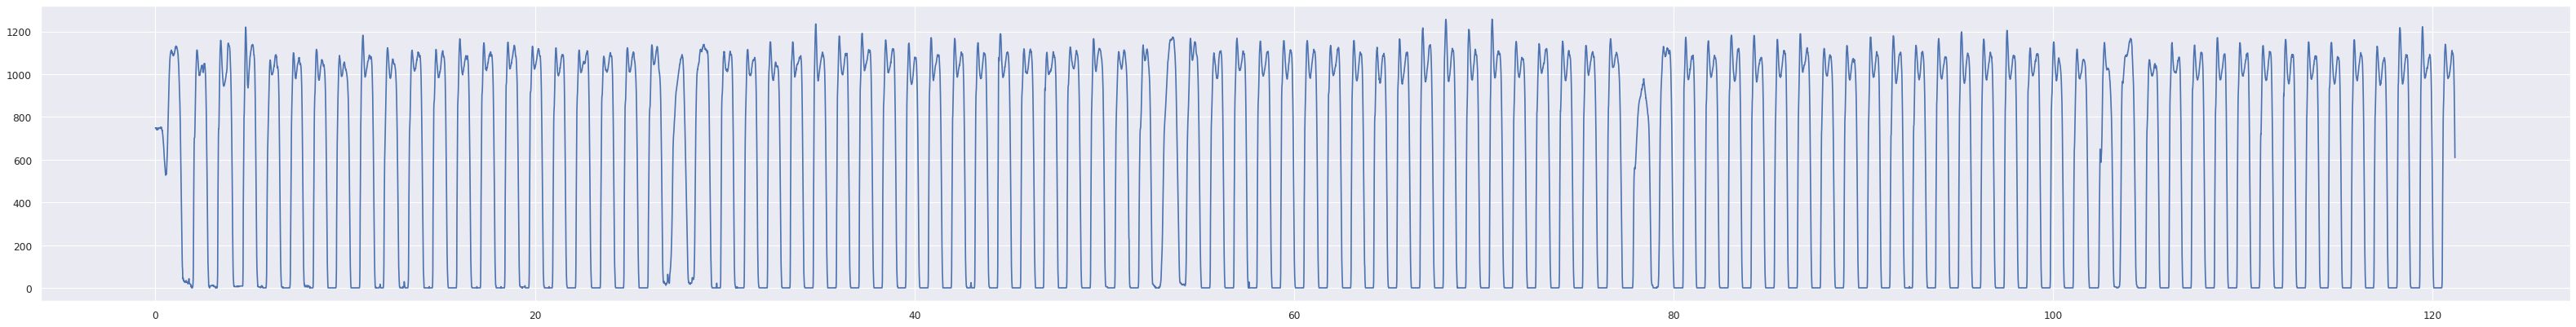

In [23]:
# Plotting VGRF

dta = data[0]
plt.figure(num=None, figsize=(50, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dta.index, dta[['VGRF_left']])
plt.figure(num=None, figsize=(50, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dta.index, dta[['VGRF_right']])